In [6]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

2024-09-20 16:48:54.010349: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 16:48:54.100553: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 16:48:54.203349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 16:48:54.294610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 16:48:54.319201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 16:48:54.488057: I tensorflow/core/platform/cpu_feature_gu

In [4]:
pip install scikit-learn

  Using cached scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (40.8 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

  Using cached tensorflow-2.17.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached protobuf-4.25.5-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached typing_exten

In [7]:
def load_features(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            features = np.loadtxt(filepath)
            data.append(features.flatten())  # Flatten the matrix to a vector
    return np.array(data)

In [8]:
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

In [12]:
def main():
    benign_path = './dump_file_benign'
    malware_path = './dump_file_malware'
    
    benign_data = load_features(benign_path)
    malware_data = load_features(malware_path)
    
    data = np.concatenate((benign_data, malware_data))
    labels = np.concatenate((np.zeros(len(benign_data)), np.ones(len(malware_data))))
    
    X_train, X_test, _, _ = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    autoencoder = build_autoencoder(X_train.shape[1])
    checkpoint = ModelCheckpoint('autoencoder.keras', save_best_only=True)
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test), callbacks=[checkpoint])
    
    # Load the best model and predict
    trained_model = load_model('autoencoder.keras')
    predictions = trained_model.predict(X_test)
    mse = np.mean(np.power(X_test - predictions, 2), axis=1)
    threshold = np.percentile(mse, 95)  # 95th percentile as threshold
    
    # Classify a new file
    new_file_path = 'dump_file_malware/0df3ce4d19f20f849183003111bca1615bb1351a939f4ee87c5dd2eb9a00febf.txt'
    new_features = np.loadtxt(new_file_path).flatten().reshape(1, -1)
    new_pred = trained_model.predict(new_features)
    new_mse = np.mean(np.power(new_features - new_pred, 2))
    
    if new_mse > threshold:
        print("The file is likely malware.")
    else:
        print("The file is likely benign.")

if __name__ == '__main__':
    main()


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 10/50
1/1 ━━━

In [15]:
malware_path = './dump_file_malware'
malware_data = load_features(malware_path)
np.ones(len(malware_data))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
 malware_data

array([[2.0888200e+06, 5.1658448e+07, 1.9633360e+06, ..., 3.4706000e+04,
        1.9985600e+05, 3.1114000e+04],
       [2.4986840e+06, 6.0659831e+07, 1.9639920e+06, ..., 3.5047000e+04,
        2.4935700e+05, 3.1115000e+04],
       [2.1334230e+06, 1.2675610e+07, 1.9652360e+06, ..., 3.4746000e+04,
        1.1769500e+05, 3.0943000e+04],
       ...,
       [2.4715950e+06, 1.5852384e+07, 2.4839500e+06, ..., 3.7348000e+04,
        1.2348500e+05, 3.3525000e+04],
       [2.6279630e+06, 6.4383209e+07, 2.2050940e+06, ..., 3.7319000e+04,
        2.0337300e+05, 3.4839000e+04],
       [2.1522490e+06, 1.0570405e+08, 2.1456860e+06, ..., 3.6528000e+04,
        2.8762200e+05, 3.2500000e+04]])

In [17]:
pip install matplotlib

  Using cached matplotlib-3.9.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-10.4.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached contourpy-1.3.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (320 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.1-cp312-cp312-manylinux_2_5_x86_64.m

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 98251051106304.0000 - val_loss: 96072395390976.0000
Epoch 10/50
1/1

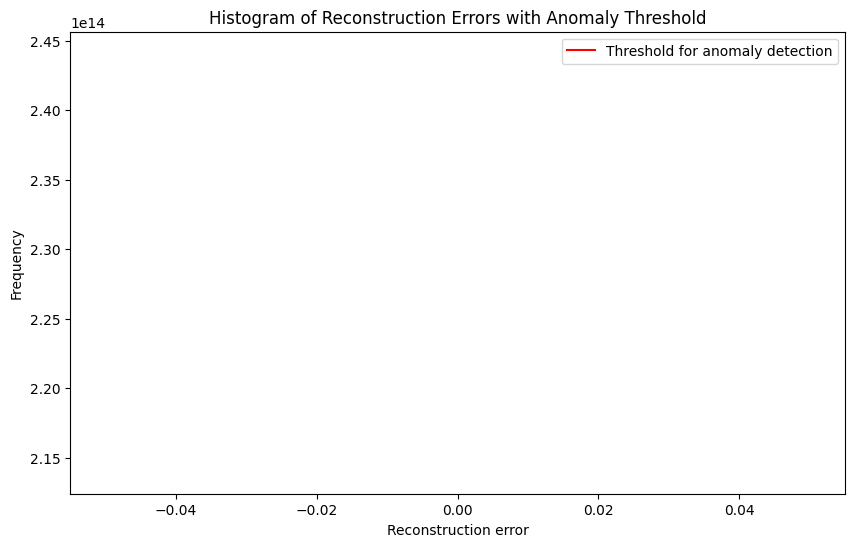

The file is likely malware.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


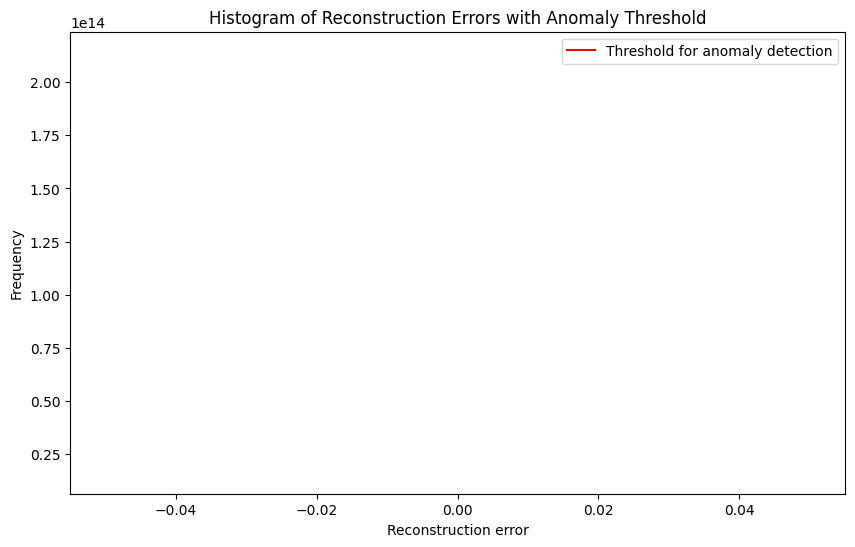

The file is likely benign.


In [39]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

In [61]:
def load_features(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            features = np.loadtxt(filepath)
            data.append(features.flatten())  # Flatten the matrix to a vector
    return np.array(data)

In [62]:
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

def plot_results(errors, threshold):
    plt.figure(figsize=(10, 6))
    plt.plot(errors)
    plt.plot(threshold, color='r', label='Threshold for anomaly detection')
    plt.title("Histogram of Reconstruction Errors with Anomaly Threshold")
    plt.xlabel("Reconstruction error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [64]:
benign_path = './dump_file_benign'
malware_path = './dump_file_malware'

benign_data = load_features(benign_path)
malware_data = load_features(malware_path)

data = np.concatenate((benign_data, malware_data))
labels = np.concatenate((np.zeros(len(benign_data)), np.ones(len(malware_data))))

In [57]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
X_train, X_test, _, _ = train_test_split(data, labels, test_size=0.2, random_state=42)

autoencoder = build_autoencoder(X_train.shape[1])
checkpoint = ModelCheckpoint('autoencoder.keras', save_best_only=True)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test), callbacks=[checkpoint])

# Load the best model and predict
trained_model = load_model('autoencoder.keras')
predictions = trained_model.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
threshold = np.percentile(mse, 95)

In [58]:
X_train.shape

(20, 1500)

In [59]:
X_test.shape

(5, 1500)

In [46]:
# Classify a new file
new_file_path = 'dump_file_malware/0df3ce4d19f20f849183003111bca1615bb1351a939f4ee87c5dd2eb9a00febf.txt'
new_features = np.loadtxt(new_file_path).flatten().reshape(1, -1)
new_pred = trained_model.predict(new_features)
new_mse = np.mean(np.power(new_features - new_pred, 2))
print(new_mse)
print(threshold)
if new_mse > threshold:
    print("The file is likely malware.")
else:
    print("The file is likely benign.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
244130516946204.97
213910926000604.2
The file is likely malware.


In [52]:
new_features.shape

(1, 1500)

In [47]:
new_file_path = 'dump_file_benign/aes.txt'
new_features = np.loadtxt(new_file_path).flatten().reshape(1, -1)
new_pred = trained_model.predict(new_features)
new_mse = np.mean(np.power(new_features - new_pred, 2))

print(new_mse)
print(threshold)
if new_mse > threshold:
    print("The file is likely malware.")
else:
    print("The file is likely benign.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
16125637539028.684
213910926000604.2
The file is likely benign.
